In [1]:
from transmission_data import transmission_function
from wigrad import Wiggler, WigglerRadiationSimulator
import numpy as np
import matplotlib.pyplot as plt
from config_ursse import get_from_config
import os
images_dir = os.path.join(get_from_config("URSSE_sync_motion_note_dir"),
                          "images")
import valstore as vt

In [2]:
wiggler = Wiggler(K_peak=get_from_config("K_peak"), N_periods=10)
x_max = 0.007257142857142857
y_max = x_max/np.sqrt(2)
n_x = int(512/4)
n_y = int(n_x/np.sqrt(2))
n_l = int(300/4)
l_min = 0.2
l_max = 1.4
x_step = x_max/(n_x-1/2)
y_step = y_max/(n_y-1/2)
l_step = (l_max-l_min)/(n_l-1)
mesh = (np.linspace(x_step/2, x_max, n_x),
        np.linspace(y_step/2, y_max, n_y),
        np.linspace(l_min, l_max, n_l))
spectral_transmission = transmission_function(mesh[2])
wr_sim0 = WigglerRadiationSimulator(
    wiggler,
    mesh,
    gamma=150/0.511,
    harmonics=[1,2,3,4,5],
    aperture='ellipse',
    only_calc_sum_of_both_polarizations=False,  # if False, then both polarizations are calculated separately
    spectral_transmission=None
    )

In [3]:
wr_sim0.calc_photon_flux_on_meshgrid()

In [4]:
wr_sim0.extend_results_using_symmetries()

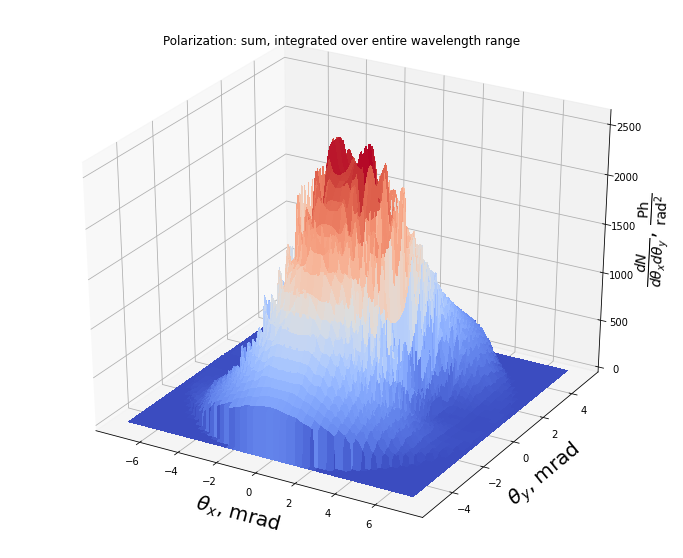

In [5]:
wr_sim0.show_angular_distribution()

In [6]:
# xs = wr_sim0.x_range
# ys = wr_sim0.y_range
# zs = wr_sim0.get_angular_distribution()
# import plotly.graph_objects as go
# fig = go.Figure(data=[go.Surface(z=zs, x=xs, y=ys)])
# fig.update_layout(title='', autosize=False,
#                   width=500, height=500,
#                   margin=dict(l=65, r=50, b=65, t=90),
#                   scene=dict(aspectratio=dict(x=1, y=1, z=1)))
# fig.show()

In [7]:
wr_sim0.get_total_photon_flux()*7.5e6

605512.4810617404

In [8]:
x_peak = 0.16  # mm
rate_center = 933  # Hz
spad_rad = 0.09 # mm
x_angle_peak = 0.002362129  # rad
spad_rad_angle = x_angle_peak/x_peak*spad_rad
np.sum(wr_sim0.get_angular_distribution()[(wr_sim0.x_2D**2+wr_sim0.y_2D**2) < spad_rad_angle**2])\
    *wr_sim0.x_step*wr_sim0.y_step*2*7.5e6

184366.65821116732

# Calculation of number of emitted photons:

In [9]:
wr_sim = WigglerRadiationSimulator(
    wiggler,
    mesh,
    gamma=150/0.511,
    harmonics=[1,2,3,4,5],
    aperture='ellipse',
    only_calc_sum_of_both_polarizations=False,  # if False, then both polarizations are calculated separately
    spectral_transmission=None
    )
wr_sim.calc_photon_flux_on_meshgrid()
wr_sim.extend_results_using_symmetries()

# Summary:

In [10]:
from transmission_data import QE, edgepass_func

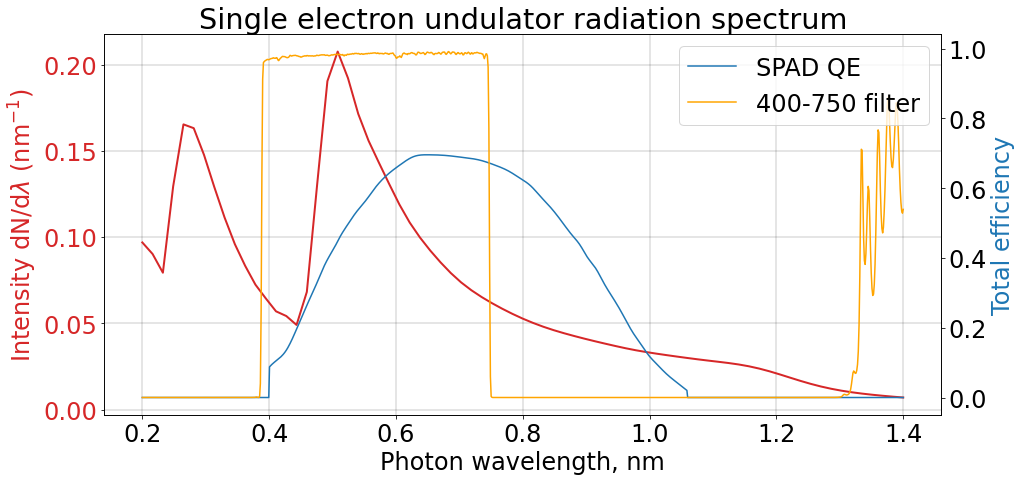

In [11]:
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)
plt.rcParams.update({'font.size': 24,'legend.fontsize':24})
fig,ax = plt.subplots(figsize=[15,7])
ax.set_xlabel('Photon wavelength, nm')
plt.title('Single electron undulator radiation spectrum')
color = 'tab:red'
ax.plot(wr_sim.lambda_range, wr_sim.get_spectral_distribution(), linewidth=2, color = color)
ax.set_ylabel(r'Intensity dN/d$\lambda$ (nm$^{-1}$)', color=color)
plt.tick_params(axis ='y',labelcolor=color) 
ax.grid(color='k', linestyle='-', linewidth=2, alpha=0.1)
l_min = 0.5
l_max = 0.8
# plt.axvline(l_min,color='orange')
# plt.axvline(l_max,color='orange')
# plt.annotate(r'$p_{theory}$ = '+'{:.6f}'.format(wr_sim0.get_total_photon_flux()),
#              ((l_min+l_max)/2, 0.2*ax.get_ylim()[1]), ha='center', fontsize=18)
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel(r'Total efficiency', color=color)  # we already handled the x-label with ax1
l_tf = np.linspace(wr_sim.lambda_range[0], wr_sim.lambda_range[-1], 1000)
ax2.plot(l_tf, QE(l_tf), color=color, label="SPAD QE")
ax2.plot(l_tf, edgepass_func('premium750.xlsx')(l_tf), color='orange', label="400-750 filter")
ax2.legend()
# ax2.tick_params(axis='y', labelcolor=color)
# ax.set_ylim(0, ax.get_ylim()[1])
# ax2.set_ylim(0, ax2.get_ylim()[1])
# align_yaxis(ax, 0, ax2, 0)
# plt.text(0.78,0.94,'Fundamental',fontsize=20,transform=ax.transAxes)
plt.show()